<a href="https://colab.research.google.com/github/ludo950/data-science-time-series/blob/main/Electric_production_forecast(LSTM%2CSARIMA).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This project uses data related to the Electric Production from 1985 to 2017 and aims to develop ML algorithms for prediction and forecasting (SARIMAX and LSTM)<br>
 LSTM RMSE:  6.20<br>
SARIMA RMSE : 4.2<br>
LSTM MAPE : 10.74<br>
SARIMA MAPE : 11.15<br>

In [404]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [405]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [406]:
df=pd.read_csv('gdrive/My Drive/Colab Notebooks/datasets/Electric_Production.csv', index_col='DATE', parse_dates=True)

In [407]:
df.head()

,Value
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


In [408]:
df.tail()

,Value
DATE,
2017-09-01,98.6154
2017-10-01,93.6137
2017-11-01,97.3359
2017-12-01,114.7212
2018-01-01,129.4048


In [409]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 397 entries, 1985-01-01 to 2018-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Value   397 non-null    float64
dtypes: float64(1)
memory usage: 6.2 KB


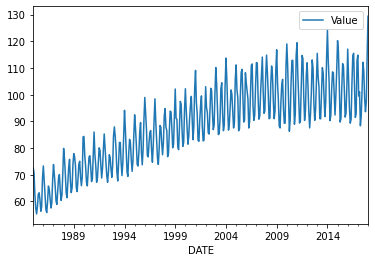

In [410]:
df.plot()

In [411]:
prediction_windows=12

In [412]:
train=df.iloc[:len(df)-prediction_windows]
test=df.iloc[len(df)-prediction_windows:]

In [413]:
from sklearn.preprocessing import MinMaxScaler

In [414]:
scaler=MinMaxScaler()

In [415]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [416]:
n_input=12 #Use 12 months data to predict 13 th month data
n_features=1 #only one time series ! not multiple time series

In [417]:
X_train=[]
y_train=[]
for i in range(n_input,len(scaled_train)):
    X_train.append(scaled_train[i-n_input:i])
    y_train.append(scaled_train[i])
X_train, y_train = np.array(X_train), np.array(y_train)

In [418]:
print(f'Given the Array: \n {X_train[0].flatten()}')
print(f'Predict this y: \n {y_train[0]}')

Given the Array: 
 [0.24934943 0.22275812 0.10349754 0.03127801 0.         0.04025686
 0.10596346 0.11507721 0.07643625 0.01450976 0.03895283 0.19436378]
Predict this y: 
 [0.26096101]


In [419]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [420]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [421]:
# define model
model = Sequential()
model.add(LSTM(150, input_shape=(n_input, n_features), return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(50, input_shape=(n_input, n_features), return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [422]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_22 (LSTM)               (None, 12, 150)           91200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 12, 150)           0         
_________________________________________________________________
lstm_23 (LSTM)               (None, 50)                40200     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 51        
Total params: 131,451
Trainable params: 131,451
Non-trainable params: 0
_________________________________________________________________


In [423]:
model.fit(X_train, y_train, epochs=100)

Epoch 1/100
12/12 [==============================] - 4s 30ms/step - loss: 0.0892
Epoch 2/100
12/12 [==============================] - 0s 27ms/step - loss: 0.0217
Epoch 3/100
12/12 [==============================] - 0s 28ms/step - loss: 0.0161
Epoch 4/100
12/12 [==============================] - 0s 28ms/step - loss: 0.0161
Epoch 5/100
12/12 [==============================] - 0s 28ms/step - loss: 0.0146
Epoch 6/100
12/12 [==============================] - 0s 27ms/step - loss: 0.0149
Epoch 7/100
12/12 [==============================] - 0s 28ms/step - loss: 0.0144
Epoch 8/100
12/12 [==============================] - 0s 29ms/step - loss: 0.0137
Epoch 9/100
12/12 [==============================] - 0s 28ms/step - loss: 0.0141
Epoch 10/100
12/12 [==============================] - 0s 28ms/step - loss: 0.0137
Epoch 11/100
12/12 [==============================] - 0s 29ms/step - loss: 0.0136
Epoch 12/100
12/12 [==============================] - 0s 28ms/step - loss: 0.0134
Epoch 13/100
12/12 [=====

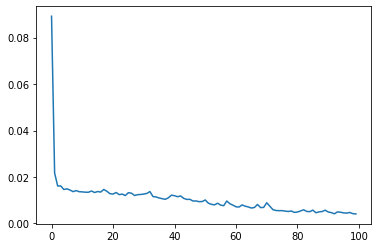

In [424]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [425]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:] # usa 12 input precedenti per predirre nuovo dato
current_batch=first_eval_batch.reshape((1,n_input,n_features)) # come visto sopra tipo (1,12,1)

for i in range(len(test)):
    #get the prediction alue for the first batch
    current_pred = model.predict(current_batch)[0]
    
    #append the prediction into the array
    test_predictions.append(current_pred)
    
    #use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis=1)

In [426]:
true_predictions = scaler.inverse_transform(test_predictions)

In [427]:
test['Predictions'] = true_predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


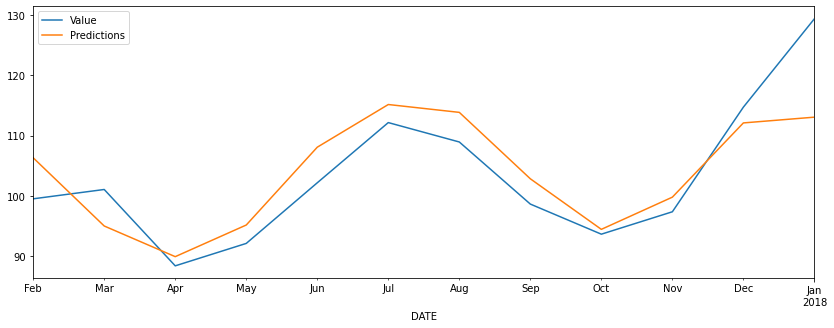

In [428]:
test.plot(figsize=(14,5))

In [429]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse_lstm=sqrt(mean_squared_error(test['Value'],test['Predictions']))
print(rmse_lstm)

6.201182437297789


In [430]:
pred_dates=np.asarray(test.index)
dates=np.asarray(df.index)

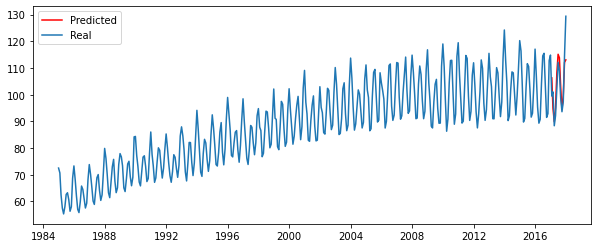

In [431]:
plt.figure(figsize=(10,4))
plt.plot(pred_dates,test['Predictions'].values,color='red',label='Predicted')
plt.plot(dates,df.values, label='Real')
plt.legend()
plt.show()

In [432]:
mape_lstm=mape(df.values[-12:], test['Predictions'].values)
mape_lstm

10.738299529246722

FORECAST

In [433]:
date_offset=12
forecast_dates =  (df.index + pd.DateOffset(months=date_offset))[-date_offset:]
forecast_dates

DatetimeIndex(['2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01',
               '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01',
               '2018-10-01', '2018-11-01', '2018-12-01', '2019-01-01'],
              dtype='datetime64[ns]', name='DATE', freq=None)

In [434]:
forecast=[]

first_eval_batch = test_predictions[-n_input:] #use the past 12 values of the predicted values to forecast
current_batch=np.reshape(first_eval_batch,(1,n_input,n_features))

for i in range(date_offset):
    #get the prediction alue for the first batch
    current_pred = model.predict(current_batch)[0]
    
    #append the prediction into the array
    forecast.append(current_pred)
    
    #use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis=1)

In [435]:
true_forecast= scaler.inverse_transform(forecast)

In [436]:
df_forecast=pd.DataFrame({'date': forecast_dates})
df_forecast.set_index('date', inplace=True)
df_forecast['forecast']=true_forecast
df_forecast.head()

,forecast
date,
2018-02-01,105.084360
2018-03-01,94.301647
2018-04-01,91.164160
2018-05-01,99.243351
2018-06-01,110.551749


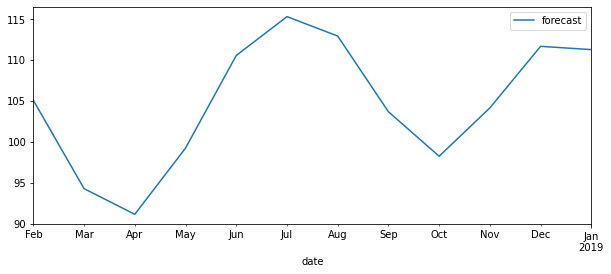

In [437]:
df_forecast.plot(figsize=(10,4))

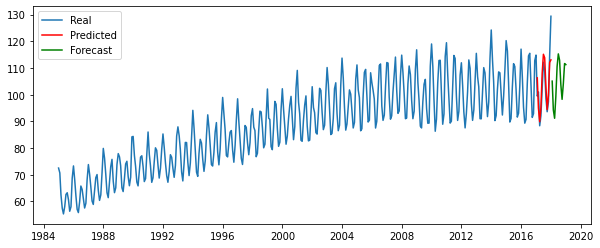

In [438]:
plt.figure(figsize=(10,4))
plt.plot(dates,df.values, label='Real')
plt.plot(pred_dates,test['Predictions'].values,color='red',label='Predicted')
plt.plot(forecast_dates,df_forecast['forecast'].values, color='green', label='Forecast')
plt.legend()
plt.show()

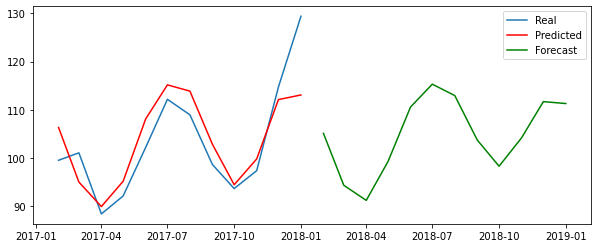

In [439]:
plt.figure(figsize=(10,4))
plt.plot(dates[-12:],df[-12:].values, label='Real')
plt.plot(pred_dates,test['Predictions'].values,color='red',label='Predicted')
plt.plot(forecast_dates,df_forecast['forecast'].values, color='green', label='Forecast')
plt.legend()
plt.show()

# PREDICTION AND FORECASTING BY SARIMAX

<Figure size 432x288 with 0 Axes>

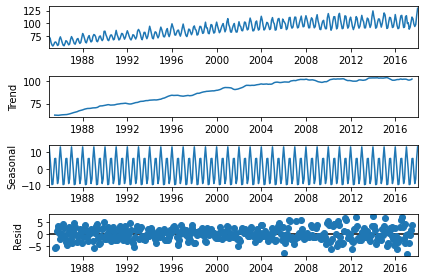

In [440]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df)

fig = plt.figure()  
fig = result.plot()

In [441]:
from statsmodels.tsa.stattools import adfuller
result=adfuller(df.Value.dropna())
print(f'ADF Statistics:{result[0]}')
print(f'p-value:{result[1]}')

ADF Statistics:-2.256990350047245
p-value:0.1862146911658677


In [442]:
result=adfuller(df.Value.diff().dropna())
print(f'ADF Statistics:{result[0]}')
print(f'p-value:{result[1]}')

ADF Statistics:-7.104890882267334
p-value:4.0777865655388604e-10


Now the series looks stationary with a 1-order difference

## ACF AND PACF

In [443]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

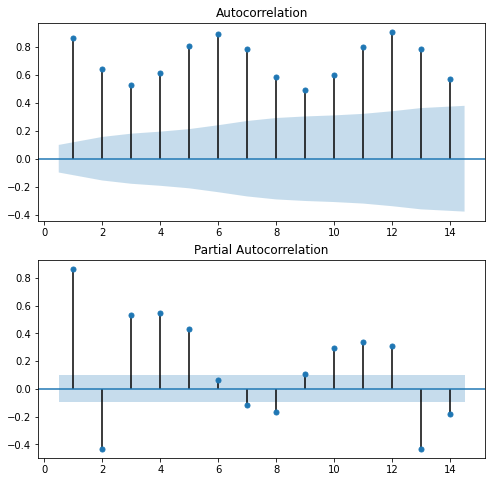

In [444]:
fig, (ax1, ax2)=plt.subplots(2,1,figsize=(8,8))

plot_acf(df,lags=14, zero=False, ax=ax1)
plot_pacf(df,lags=14, zero=False, ax=ax2)
plt.show()

The series looks indeed non stationary

## AUTO ARIMA

In [445]:
!pip install pmdarima
import pmdarima as pm

In [446]:
results=pm.auto_arima(df, d=1, start_p=1, start_q=1, max_p=3, max_q=3,
                    seasonal=True, m=6, D=1, start_P=1, start_Q=1, max_P=2, max_Q=2, information_criterion='aic', trace=True, error_action='ignore', stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[6]             : AIC=1912.925, Time=0.75 sec
 ARIMA(0,1,0)(0,1,0)[6]             : AIC=2404.500, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[6]             : AIC=1998.731, Time=0.18 sec
 ARIMA(0,1,1)(0,1,1)[6]             : AIC=2057.803, Time=0.31 sec
 ARIMA(1,1,1)(0,1,1)[6]             : AIC=2000.250, Time=0.58 sec
 ARIMA(1,1,1)(1,1,0)[6]             : AIC=inf, Time=0.53 sec
 ARIMA(1,1,1)(2,1,1)[6]             : AIC=1880.044, Time=1.17 sec
 ARIMA(1,1,1)(2,1,0)[6]             : AIC=inf, Time=0.87 sec
 ARIMA(1,1,1)(2,1,2)[6]             : AIC=inf, Time=2.74 sec
 ARIMA(1,1,1)(1,1,2)[6]             : AIC=inf, Time=2.06 sec
 ARIMA(0,1,1)(2,1,1)[6]             : AIC=1925.181, Time=0.80 sec
 ARIMA(1,1,0)(2,1,1)[6]             : AIC=1942.791, Time=0.65 sec
 ARIMA(2,1,1)(2,1,1)[6]             : AIC=1881.313, Time=1.81 sec
 ARIMA(1,1,2)(2,1,1)[6]             : AIC=1880.682, Time=1.51 sec
 ARIMA(0,1,0)(2,1,1)[6]             : AIC=1955.485, T

In [447]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model=SARIMAX(df,order=(2,1,2),  seasonal_order=(1, 1, 2, 6))
results=model.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [448]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             Value   No. Observations:                  397
Model:             SARIMAX(2, 1, 2)x(1, 1, 2, 6)   Log Likelihood                -899.089
Date:                           Fri, 10 Sep 2021   AIC                           1814.177
Time:                                   14:55:15   BIC                           1845.907
Sample:                               01-01-1985   HQIC                          1826.755
                                    - 01-01-2018                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0873      0.350     -0.249      0.803      -0.773       0.599
ar.L2          0.2828      0.214      1.321      0.187      -0.137       0.702
ma.L1         -0.2982      0.337     -0.884      0.377      -0.959       0.363
ma.L2         -0.6397      0.329     -1.944      0.052      -1.285       0.005
ar.S.L6       -0.9976      0.003   -380.173      0.000      -1.003      -0.992
ma.S.L6        0.1145      0.040      2.832      0.005       0.035       0.194
ma.S.L12      -0.7764      0.037    -20.853      0.000      -0.849      -0.703
sigma2         5.5549      0.307     18.092      0.000       4.953       6.157
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                42.26
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               2.75   Skew:                            -0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# ARIMA MODEL FIT

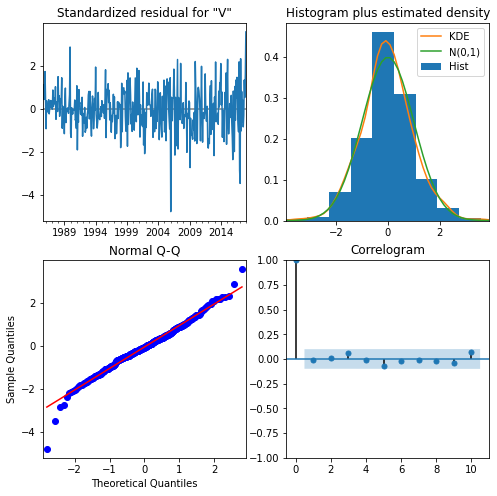

In [449]:
# Create the 4 diagostics plots
results.plot_diagnostics(figsize=(8,8))
plt.show()

# SARIMA PREDICTION

In [450]:
prediction = results.get_prediction(start=-12)
mean_prediction=prediction.predicted_mean

mean_prediction.size

12

In [451]:
confi_int_p=prediction.conf_int()
lower_limits_p=confi_int_p.iloc[:,0]
upper_limits_p=confi_int_p.iloc[:,1]
confi_int_p.shape

(12, 2)

In [452]:
pred_dates=np.asarray(mean_prediction.index)
dates=np.asarray(df.index)

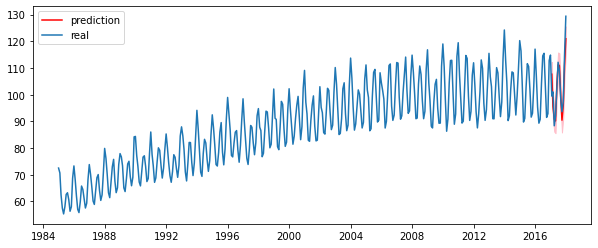

In [453]:
plt.figure(figsize=(10,4))
plt.plot(pred_dates,mean_prediction.values,color='red',label='prediction')
plt.fill_between(pred_dates, lower_limits_p, upper_limits_p, color='pink')
plt.plot(dates,df.values, label='real')
plt.legend()
plt.show()

In [454]:
mape_sarima = mape(df[-12:].values,mean_prediction.values)

In [455]:
rmse_sarima = sqrt(mean_squared_error(df[-12:].values,mean_prediction.values))
print(rmse_sarima)

4.193259967100493


# SARIMA FORECAST

In [456]:
# Make ARIMA forecast of next 10 values
forecast = results.get_forecast(steps=12)
mean_forecast=forecast.predicted_mean
mean_forecast.size

12

In [457]:
confi_int_f=forecast.conf_int()
lower_limits_f=confi_int_f.iloc[:,0]
upper_limits_f=confi_int_f.iloc[:,1]

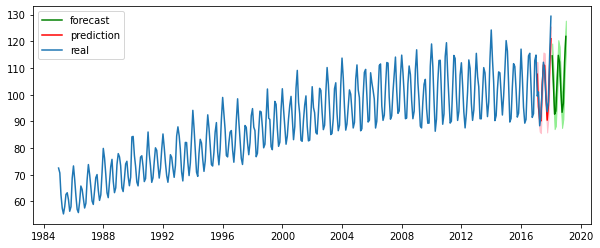

In [458]:
forec_dates=np.asarray(mean_forecast.index)
pred_dates=np.asarray(mean_prediction.index)
dates=np.asarray(df.index)
plt.figure(figsize=(10,4))
plt.plot(forec_dates,mean_forecast.values,color='green',label='forecast')
plt.fill_between(forec_dates, lower_limits_f, upper_limits_f, color='lightgreen')

plt.plot(pred_dates,mean_prediction.values,color='red',label='prediction')
plt.fill_between(pred_dates, lower_limits_p, upper_limits_p, color='pink')

plt.plot(dates,df.values, label='real')
plt.legend(loc='upper left')
plt.show()

In [459]:
print('LSTM RMSE: ', rmse_lstm)
print('SARIMA RMSE :', rmse_sarima)
print('LSTM MAPE :', mape_lstm)
print('SARIMA MAPE :', mape_sarima)

LSTM RMSE:  6.201182437297789
SARIMA RMSE : 4.193259967100493
LSTM MAPE : 10.738299529246722
SARIMA MAPE : 11.154561905289137


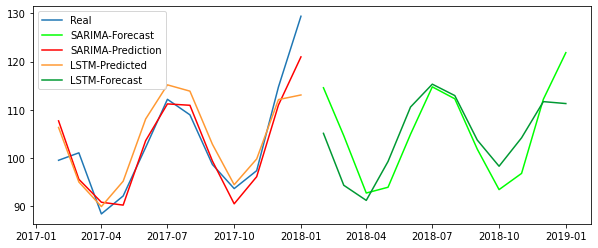

In [460]:
plt.figure(figsize=(10,4))
plt.plot(dates[-12:],df[-12:].values, label='Real') 
plt.plot(forec_dates,mean_forecast.values,color='#00ff00',label='SARIMA-Forecast')
plt.plot(pred_dates,mean_prediction.values,color='#ff0000',label='SARIMA-Prediction')
plt.plot(pred_dates,test['Predictions'].values,color='#ff9933',label='LSTM-Predicted')
plt.plot(forecast_dates,df_forecast['forecast'].values, color='#009933', label='LSTM-Forecast')
plt.legend(loc='upper left')
plt.show()